In [1]:
%cd ../../

/home/novelli/encoderops


In [2]:
from dotenv import load_dotenv
import xarray as xr
from pathlib import Path
import os
import torch
from src.data import SSTDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pathlib import Path
from src.model import EvolutionOperator
from src.data import SSTDataModule
from src.configs import TrainerArgs, SSTDataArgs # noqa

load_dotenv()

True

In [3]:
run_id = "jy9mhapa"
ckpt_path = f"/home/novelli/encoderops/logs/encoderops-ENSO/{run_id}/checkpoints/last.ckpt"

In [7]:
model = EvolutionOperator.load_from_checkpoint(ckpt_path)
data_args = torch.load(ckpt_path, weights_only=False)['SSTDataModule']['data_args']
data_args = SSTDataArgs(**data_args)
datamodule = SSTDataModule(model.trainer_args, data_args = data_args, num_workers = 1)
datamodule.setup("fit")

2025-05-21 17:38:44.781 | INFO     | src.data:__init__:575 - Dataset loaded with 454 samples.
2025-05-21 17:38:45.913 | INFO     | src.data:__init__:575 - Dataset loaded with 82 samples.


In [33]:
emb_X = []
emb_Y = []
emb_YP = []
X = []
Y = []
model.eval()
with torch.no_grad():
    for sample in datamodule.train_dataset:
        x = sample['x'].to(model.device).unsqueeze(0)
        y = sample['y'].to(model.device).unsqueeze(0)        
        emb_X.append(model.forward_nn(x))
        X.append(x[0,0])
        emb_Y.append(model.forward_nn(y))
        emb_YP.append(model.forward_nn(y, lagged=True))
        Y.append(y[0,0])
emb_X = torch.cat(emb_X)
emb_Y = torch.cat(emb_Y)
emb_YP = torch.cat(emb_YP)
X = torch.stack(X)
Y = torch.stack(Y)

In [34]:
K = (emb_X@emb_YP.T).numpy(force=True)

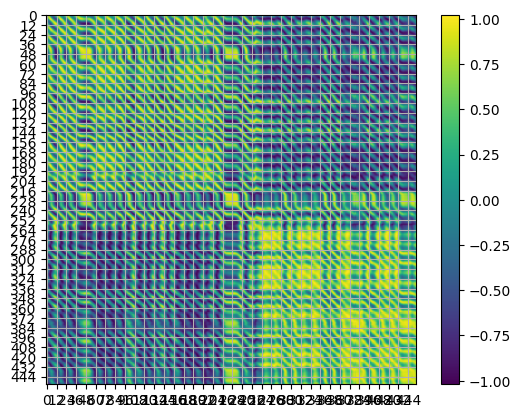

In [37]:
plt.imshow(K)
plt.grid()
import numpy as np
major_ticks = np.arange(0, K.shape[0], 12)

plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.colorbar()

In [7]:
dl = DataLoader(dataset, batch_size = 10)

In [9]:
next(iter(dl))['x'].shape

torch.Size([10, 2, 121, 240])

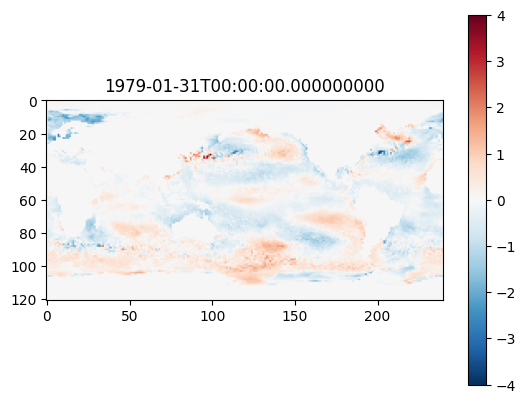

In [21]:
idx = 0
_data = dataset[idx]
plt.imshow(_data['x'][0], cmap="RdBu_r", vmin=-4, vmax=4)
plt.title(_data['time'][0])
plt.colorbar()

In [22]:
t = dataset.oni.time
oni = dataset.oni.__xarray_dataarray_variable__.values
oni_full = dataset.oni_full.__xarray_dataarray_variable__.values

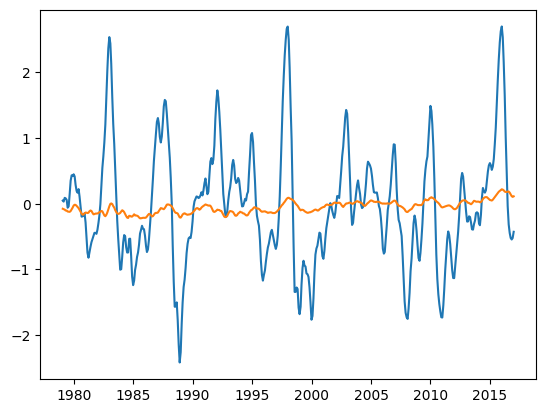

In [23]:
plt.plot(t, oni)
plt.plot(t, oni_full)

In [14]:
data = dataset.data
mean = data.mean(axis = 0)
std = data.std(axis=0)

data_std = (data - mean)/std

/tmp/ipykernel_1268673/2691434972.py:5: RuntimeWarning: invalid value encountered in divide
  data_std = (data - mean)/std


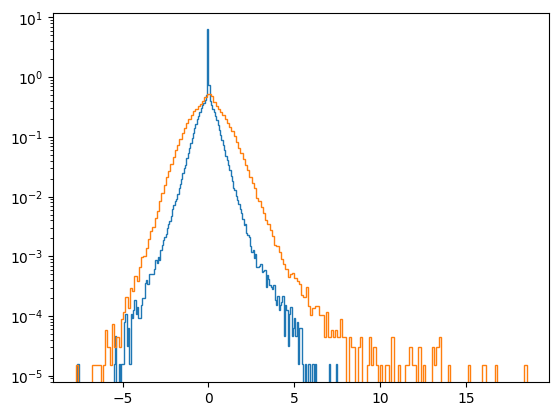

In [15]:
plt.hist(data[:, ::4, ::4].flatten(), bins=200, log=True, density=True, histtype='step');
plt.hist(data_std[:, ::4, ::4].flatten(), bins=200, log=True, density=True, histtype='step');

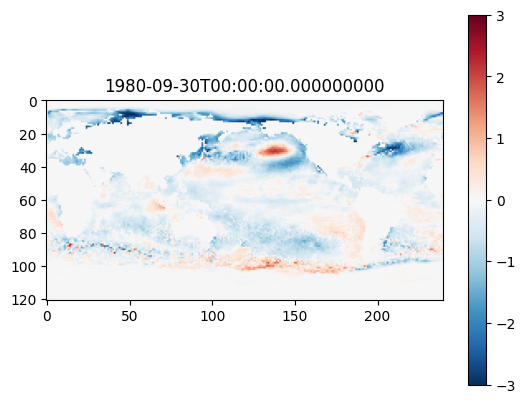

In [27]:
idx = 20
plt.imshow(data[idx], cmap="RdBu_r", vmin=-3, vmax = 3)
plt.title(dataset.time[idx])
plt.colorbar()

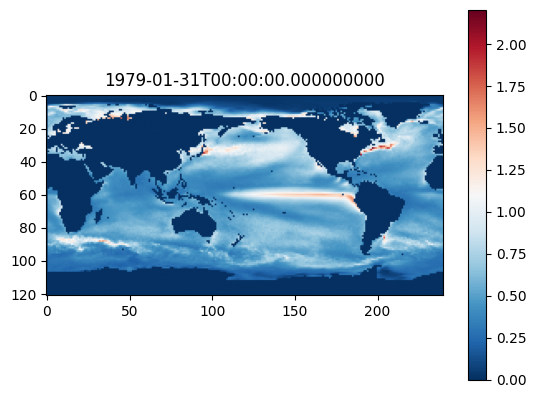

In [24]:
plt.imshow(std, cmap="RdBu_r")
plt.title(dataset.time[idx])
plt.colorbar()